<a href="https://colab.research.google.com/github/ezulfica/School-Projects/blob/main/High_dimensionality_regression_and_sparsity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#High dimensionality regression and sparsity

The main goal of this project, is to compare high dimensionality regression estimator : Lasso, Ridge and ElasticNet

In [2]:
import numpy as np
np.random.seed(seed=35)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import ElasticNet, Lasso, Ridge, lasso_path, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

import urllib
import warnings
warnings.filterwarnings("ignore")

In [5]:
class RegEstimation :

  '''
  Settings for ours models
  estimator is a dictionnary with primary key the name of the estimator
  the subs_keys are the scikit class (or another if it works with gridsearch/randomsearchcv) and the parameters
  '''

  def __init__(self, estimators):
    self.estimators = estimators
    self.best_estimators = {} #after fitting our model with cross validation, we will stock the best for each model in the dictionnary 

  def fit(self, cv, n_iter, score, X_train, y_train) : 
    ''' As sklearn fitting method, the fit function train our models and add the best 
    in the best_estimators dictionnary'''
    for estim in self.estimators : 
      X_train = StandardScaler().fit_transform(X_train)
      random_grid = RandomizedSearchCV(
        estimator = self.estimators[estim]["estimator"], 
        param_distributions = self.estimators[estim]["parameters"], 
        scoring = score,
        cv = cv, 
        verbose = 0, 
        n_jobs = -1, 
        n_iter = n_iter)
      random_grid.fit(X_train,y_train)
      
      self.best_estimators[estim] = {
        "estimator" : random_grid.best_estimator_ ,
        "parameters" : random_grid.best_params_ ,
        "score" : random_grid.best_score_ ,
      }

  def show_best(self) : 
    '''Print the best parameters for each model'''
    for estim in self.estimators : 
      print(f'------------ {estim} ------------' )
      print(f' Best parameters : {self.best_estimators[estim]["parameters"]}')
      print(f' MSE on train set = {-np.round(self.best_estimators[estim]["score"], 2)} ')
      print("\n")

  def predict(self, X_test):
    ''' Return a prediction for each model with the best parameters '''
    X_test = StandardScaler().fit_transform(X_test)
    predict = {}
    for estim in estimators : 
      predict[estim] = self.best_estimators[estim]["estimator"].predict(X_test)
    return(predict)

  def plot_estimation(self, X_test, y_test) : 
    ''' Since in our case we have a lot of features, we will only plot our prediction and test y values
    in discontinuous time '''
    X_test = StandardScaler().fit_transform(X_test)
    fig, ax = plt.subplots(nrows = len(self.estimators), ncols = 1, figsize = (17,12))
    i = 0
    for estim in estimators : 
      predict = self.best_estimators[estim]["estimator"].predict(X_test)
      mse_pred = np.round(mean_squared_error(y_test, predict), 2)
      x_coord, y_coord = len(y_test) - 30 , np.max(np.concatenate([y_test, predict])) - 7
      ax[i].plot(predict, c = "red", label= estim.capitalize())
      ax[i].plot(y_test, c = "black", label = "y", alpha = 0.4)
      ax[i].legend(frameon=False, loc='lower center', ncol=2)
      ax[i].set_title(f'{estim.capitalize()} estimation')
      i += 1
      print(f'MSE for {estim} = {np.round(mse_pred,2)}')
    plt.show();

In [6]:
estimators = {
    "elasticnet" : {
        "estimator" : ElasticNet() , 
        "parameters" : {
            "l1_ratio" : np.linspace(0,.5,50), #LASSO if 1, RIDGE if 0
            "alpha" : np.linspace(0,1, 50)
        }
      },
      
      "lasso" : {
        "parameters" : {"alpha" : np.linspace(0,.5, 50)}, 
        "estimator" : Lasso()
      },

      "ridge" : {
        "parameters" : {"alpha" : np.linspace(0,.5, 50)}, 
        "estimator" : Ridge()
        }
}

# First modelling

Let's assume :  
$$ y = X \beta + \eta $$ 
where $\beta_1 = ... = \beta_{15} = 1$ and $\beta_i = 0$ for $i > 15$

$X$ and $\eta$ are independant normal distributed variables. 

### Lasso Path

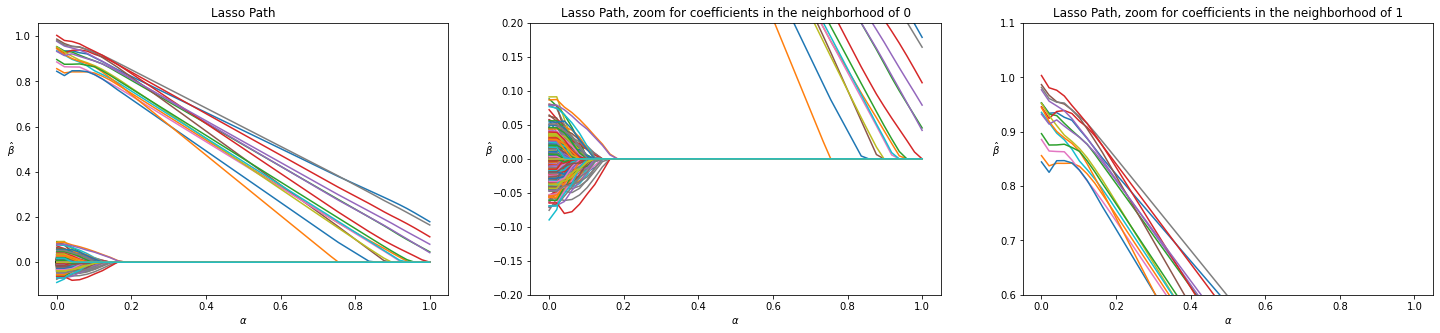

In [7]:
s = 15
p = 5000
n = 1000
beta = np.array([1 for i in range(s)] + [0 for i in range(p-s)])
#beta = np.random.randn(p)
eta = np.random.randn(n)
X = np.random.randn(n,p)
y = np.matmul(X, beta) + eta
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2/3)

alpha_val , coeff_lasso, _ = lasso_path(X_train, y_train, eps = 2e-2, positive=False, alphas= np.linspace(0,1,50))

fig, ax = plt.subplots(1,3, figsize = (25,5))
#fig.suptitle('Lasso Path for our linear model, with sparsity s = 15')
for i in range(coeff_lasso.shape[0]):
  ax[0].plot(alpha_val, coeff_lasso[i])
  ax[1].plot(alpha_val, coeff_lasso[i])
  ax[2].plot(alpha_val, coeff_lasso[i])

for i in range(3) : 
  ax[i].set_xlabel(r'$\alpha$')
  ax[i].set_ylabel(r"$\hat{\beta}$", rotation=0)

ax[0].set_title("Lasso Path")
ax[1].set_title("Lasso Path, zoom for coefficients in the neighborhood of 0")
ax[2].set_title("Lasso Path, zoom for coefficients in the neighborhood of 1")
ax[1].set_ylim(bottom = -0.2, top = 0.2)
ax[2].set_ylim(bottom = 0.6, top = 1.1)


plt.show();

Since we know our model, we can see how close the Lasso is when $\alpha$ is in the neighborhood of 0.15 to estimate our coefficients. 

### Comparison between Lasso, Ridge and ElasticNet

------------ elasticnet ------------
 Best parameters : {'l1_ratio': 0.4897959183673469, 'alpha': 0.12244897959183673}
 MSE on train set = 1.99 


------------ lasso ------------
 Best parameters : {'alpha': 0.1020408163265306}
 MSE on train set = 1.31 


------------ ridge ------------
 Best parameters : {'alpha': 0.5}
 MSE on train set = 15.41 


Estimation on test set 

MSE for elasticnet = 1.67
MSE for lasso = 1.3
MSE for ridge = 14.35


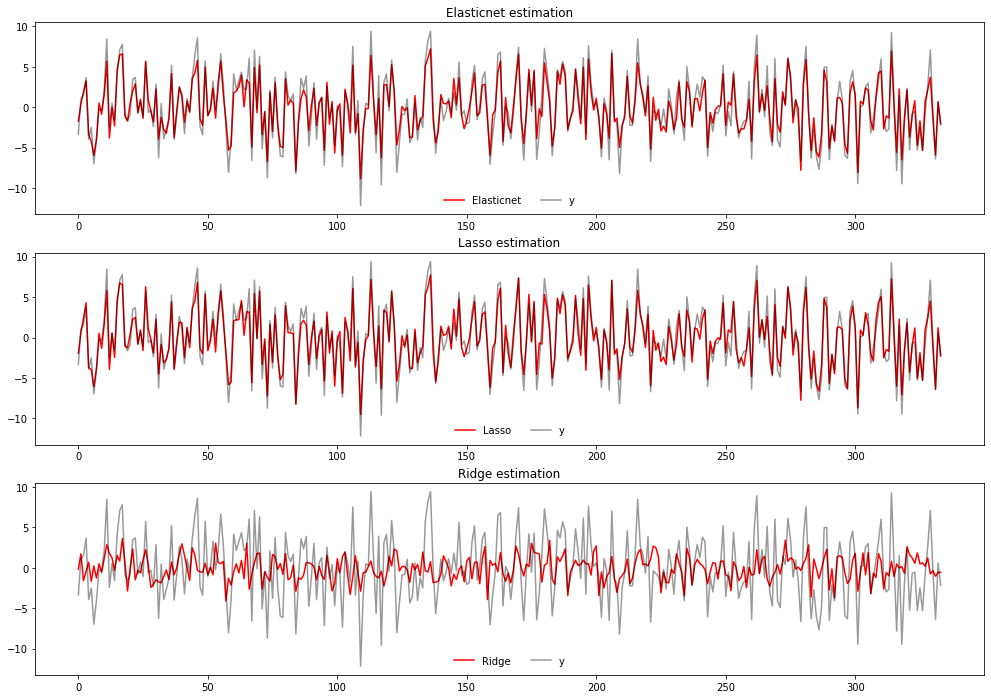

In [ ]:
regression_estimator1 = RegEstimation(estimators)
regression_estimator1.fit(cv= 5, n_iter = 75, score = "neg_mean_squared_error", X_train = X_train,y_train = y_train)
regression_estimator1.show_best()
print("Estimation on test set \n")
regression_estimator1.plot_estimation(X_test, y_test, scale = True)

# Second modelling

Let's assume :  
$$ y = X \beta + \eta $$ 
where $\beta_1 = ... = \beta_{1500} = 1$ and $\beta_i = 0$ for $i > 1500$

$X$ and $\eta$ are independant normal distributed variables. 

------------ elasticnet ------------
 Best parameters : {'l1_ratio': 0.0, 'alpha': 0.061224489795918366}
 MSE on train set = 1265.34 


------------ lasso ------------
 Best parameters : {'alpha': 0.01020408163265306}
 MSE on train set = 1556.14 


------------ ridge ------------
 Best parameters : {'alpha': 0.0}
 MSE on train set = 1264.98 


Estimation on test set 

MSE for elasticnet = 1230.58
MSE for lasso = 1718.33
MSE for ridge = 1230.51


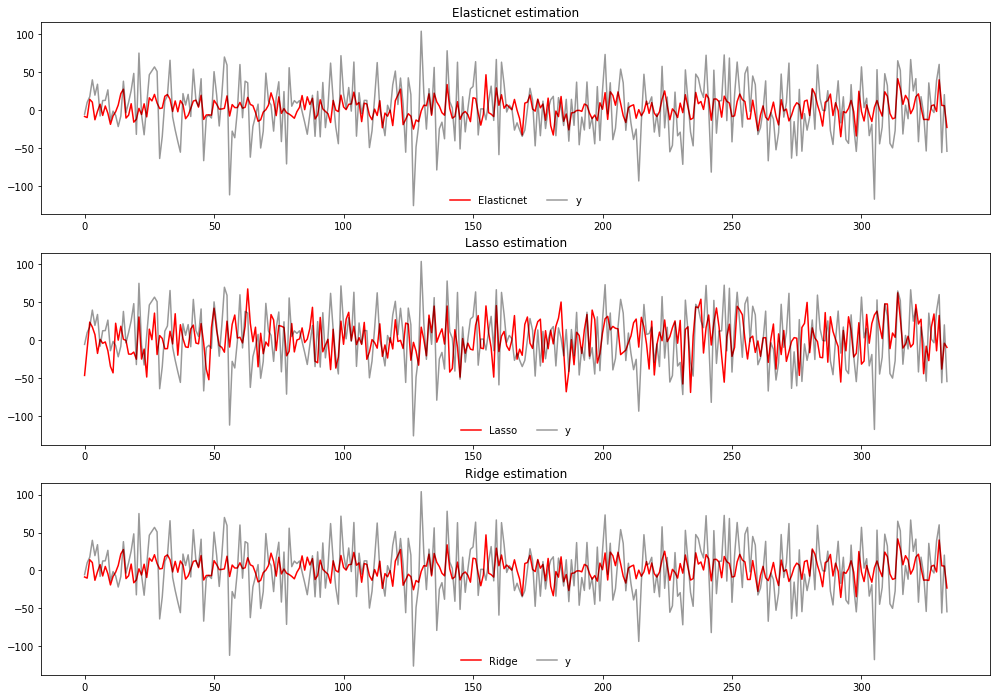

In [ ]:
s = 1500
p = 5000
n = 1000
beta = np.array([1 for i in range(s)] + [0 for i in range(p-s)])
eta = np.random.randn(n)
X = np.random.randn(n,p)
y = np.matmul(X, beta) + eta
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2/3)

regression_estimators2 = RegEstimation(estimators)
regression_estimators2.fit(cv= 5, n_iter = 75, score = "neg_mean_squared_error", X_train = X_train,y_train = y_train)

regression_estimators2.show_best()
print("Estimation on test set \n")
regression_estimators2.plot_estimation(X_test, y_test, scale = True)

# Third modelling

Let's assume :  
$$ y = X \beta + \eta $$ 
where $\beta_1 = \beta_2 = 5$, $\beta_3 = \beta_4 = 10$, $\beta_5 = ... = \beta_{14} = 1$ and $\beta_i = 0$ for $i > 14$

$X$ and $\eta$ are normal distributed variables with : 
$$ \mathrm{cov}(X_{k,i}, X_{k,j}) = 0.7^{|i-j|} $$

------------ elasticnet ------------
 Best parameters : {'l1_ratio': 0.4693877551020408, 'alpha': 0.02040816326530612}
 MSE on train set = 3.29 


------------ lasso ------------
 Best parameters : {'alpha': 0.11224489795918366}
 MSE on train set = 2.15 


------------ ridge ------------
 Best parameters : {'alpha': 0.5}
 MSE on train set = 4.85 


Estimation on test set 

MSE for elasticnet = 12.39
MSE for lasso = 11.6
MSE for ridge = 13.87


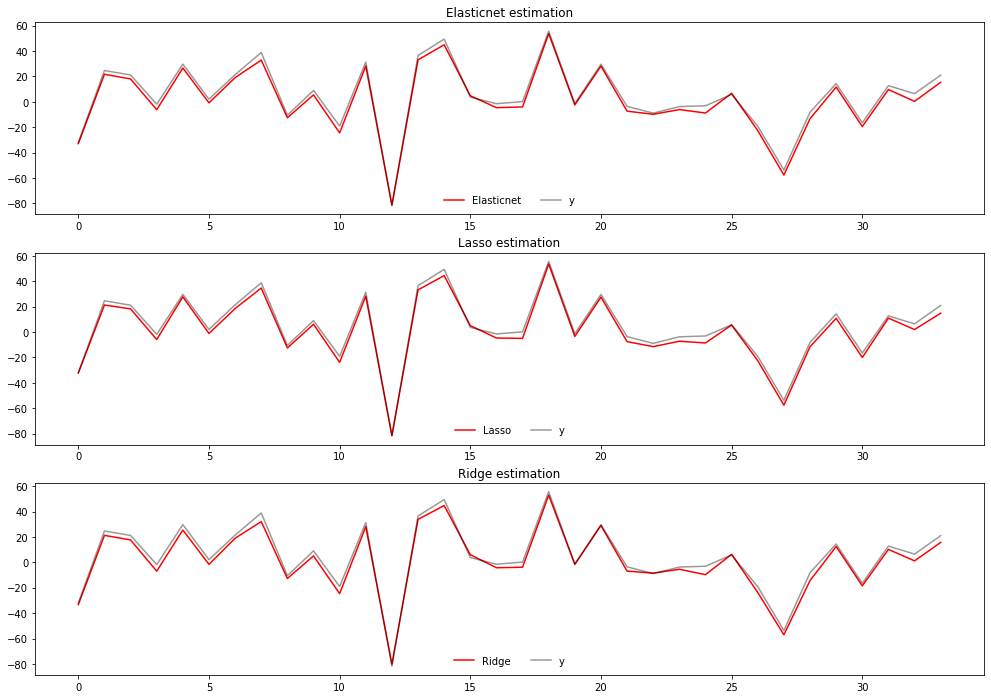

In [ ]:
s = [10,10,5,5] + [1 for i in range(10)]
p = 50
n = 100

#Covariance matrix
COV_MAT = np.zeros((p,p))
for i in range(p) :
  for j in range(p) : 
    COV_MAT[i][j] = 0.7**(np.abs((i+1)-(j+1)))

beta = np.array([i for i in s] + [0 for i in range(p-len(s))])
eta = np.random.randn(n)

#Using numpy multivariate normal to generate our correlated gaussian. 
#It is also possible to decompose our covariance matrix using choleski decomposition and then
#simulate a random normal vector of size p, n times, and multiplicate the matrix
X = X = np.random.multivariate_normal(np.zeros(p), COV_MAT, size = n) 

y = np.matmul(X, beta) + eta


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2/3)
regression_estimators3 = RegEstimation(estimators)
regression_estimators3.fit(cv= 10, n_iter = 150, score = "neg_mean_squared_error", X_train = X_train,y_train = y_train)
regression_estimators3.show_best()
print("Estimation on test set \n")
regression_estimators3.plot_estimation(X_test, y_test, scale = True)

# Conclusion

Depending on the case, it is better to choose between Lasso and Ridge.

ElasticNet is a good compromise between both, it compensate for each of them where they are lacking. We can see it in the three example, ElasticNet have almost similar performence than the best on each case. 

There is also some limitations. 
First, in the third example, Lasso performs better but is theorically weak with correlated features. And if we test it, ordinal least square is better for this case. 

Secondly, our cross validation is looking for parameters randomly through a RandomSearchCV which might not give the optimal parameters. 

# Study-case : Gas sensor array under flow modulation Data Set 
https://archive.ics.uci.edu/ml/datasets/Gas+sensor+array+under+flow+modulation

Our databse is about estimate the rates of ethanol and acetone in the air through sensor measuring. There is 16 differents sensors and twelwe differents mixture of eth-ace. 

We have 7509 features for 928 observations, including two targets which are ace_conc and eth_conc.

In [ ]:
#Downloading and loading data from UCI-Machine Learning
link_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/00308/pulmon.zip"
downloaded_filename = '/content/data.zip'
urllib.request.urlretrieve(link_data, downloaded_filename)
!unzip 'data.zip' -d '/content/data/' 
!gzip -d "/content/data/rawdata.csv.gz"
df = pd.read_csv("/content/data/rawdata.csv")

Archive:  data.zip
  inflating: /content/data/features.csv  
  inflating: /content/data/rawdata.csv.gz  


In [ ]:
X = df.select_dtypes("number") #Looking for quantitative variables
X.drop(columns = ["sample", "exp", "ace_conc", "eth_conc"], inplace = True) #droping not necessary features and our targets
y = df[["eth_conc" , "ace_conc"]] #targets
X = pd.concat([X, pd.get_dummies(df['batch'])], axis = 1) #Encoding the time where mixture has been measured
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 2/3)

In [ ]:
RegModel = RegEstimation(estimators)
RegModel.fit(cv= 5, n_iter = 30, score = "neg_mean_squared_error", X_train = X_train,y_train = y_train)
#RegModel1 = RegEstimation(estimators)
#RegModel1.fit(cv= 5, n_iter = 15, score = "neg_mean_squared_error", X_train = X_train,y_train = y_train["eth_conc"])
#RegModel2 = RegEstimation(estimators)
#RegModel2.fit(cv= 5, n_iter = 15, score = "neg_mean_squared_error", X_train = X_train,y_train = y_train["ace_conc"])

In [ ]:
RegModel.show_best()

------------ elasticnet ------------
 Best parameters : {'l1_ratio': 0.04081632653061224, 'alpha': 0.16326530612244897}
 MSE on train set = 0.06 


------------ lasso ------------
 Best parameters : {'alpha': 0.01020408163265306}
 MSE on train set = 0.06 


------------ ridge ------------
 Best parameters : {'alpha': 0.4387755102040816}
 MSE on train set = 0.05 




The three of them seems to perform well with the train set, let's see with the test set. 

In [ ]:
y_pred = RegModel.predict(X_test)
for estim in y_pred : 
  print(f"{estim} : ")
  print(f"MSE on test set :{mean_squared_error(y_test, y_pred[estim])}")

elasticnet : 
MSE on test set :0.07093900347275643
lasso : 
MSE on test set :0.07377058053206212
ridge : 
MSE on test set :0.04804957969034924


The mean squared error is lower with the Ridge. It was also the case with the second example when the sparsity was lower than the first example. 

Let's plot our prediction to see how close ther are from the real concoction with the Ridge estimator

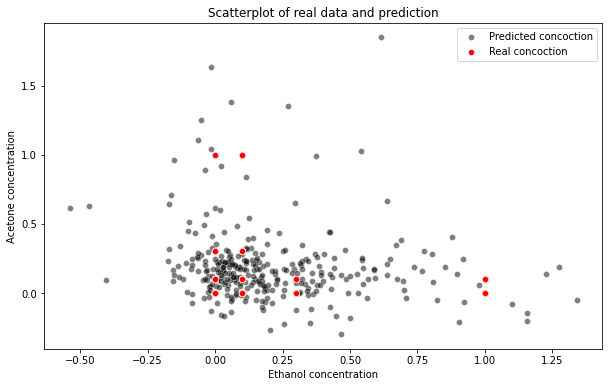

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
sns.scatterplot(data = pd.DataFrame(y_pred["ridge"]), x = 0, y = 1, alpha = 0.5, ax = ax, color = "black")
sns.scatterplot(data = y_test, x = y_test.columns[0], y = y_test.columns[1], ax = ax, color = "red")
ax.set_xlabel("Ethanol concentration")
ax.set_ylabel("Acetone concentration")
ax.legend(['Predicted concoction','Real concoction'], loc = "best")
ax.set_title("Scatterplot of real data and prediction")
plt.show();


For the area between $[0,0.25]\times[0,0.3]$ it's seem difficult to judge whereas the estimation seems good (which is pretty normal with our plot, since we are not looking it with the features). 